In [27]:
from gensim.models import KeyedVectors

input_file = './util/glove.6B.100d.txt'
model_glove = KeyedVectors.load_word2vec_format(input_file,
                                                binary=False,
                                                no_header=True)

In [28]:
from gensim.models import KeyedVectors

# Load the model
filename = './util/GoogleNews-vectors-negative300.bin'
model_wv = KeyedVectors.load_word2vec_format(filename, binary=True)

In [29]:
import fasttext
model_ft = fasttext.load_model('./util/cc.en.300.bin')

In [30]:
all_models = [model_glove, model_ft, model_wv]
model_names = ['glove', 'fasttext', 'word2vec']

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [33]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [34]:
df = pd.read_csv("./sample-clothes.csv")
df = df[['Review', 'Title']].reset_index(names='id').rename(columns={'Review': 'review'})
df['review'] = df['Title'] + ' '+ df['review']
df = df.drop('Title', axis=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      100 non-null    int64 
 1   review  100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB
None


,id,review
0,0,So flattering and so comfortable! I am in love...
1,1,"Cute but It Pills Great color and pattern, wit..."
2,2,It fell apart after one wash One set fell apar...
3,3,"Comfortable, nice color, but LOTS of pilling. ..."
4,4,"Cute dress that.even a short, skinny old woman..."


# Normalization

In [35]:
# Tokenization into sentence

df_st = df[['id', 'review']].copy()

# Sentence Tokenization
df_st['token_sentence'] = df_st['review'].apply(norm.sentence_tokenize)
df_st = df_st.explode('token_sentence')
df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# Remove non-ASCII
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_non_ascii)

# Expand contractions
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

# Get Aspect

In [36]:
# Get aspect from rules
tqdm.pandas()
df_st['sub_aspect'] = df_st['token_clean']\
                        .progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [00:26<00:00, 19.27it/s]


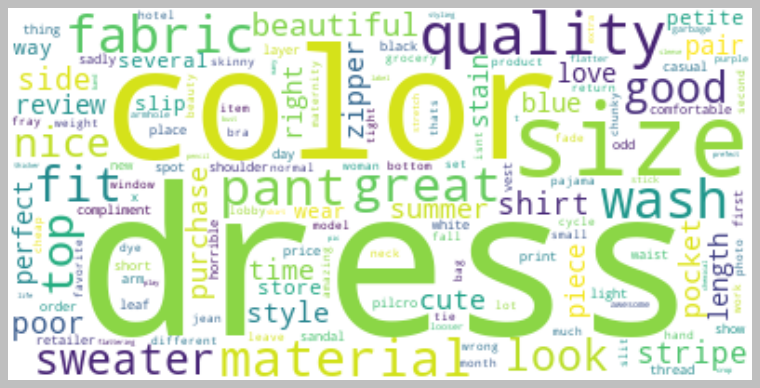

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_st['sub_aspect'].values
for i in range(df_st.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [38]:
aspects = ['color', 'size', 'material']

def fun1(x):
    temp = set()
    for e in x:
        aspect = util.ensemble_nearest_word(aspects, e, all_models)
        if aspect:
            temp.add(aspect)
    temp = list(temp)
    return temp


tqdm.pandas()
df_st['aspect'] = df_st['sub_aspect'].progress_apply(fun1)
df_st

100%|███████████████████████████████████████████████████████████████████████████████| 520/520 [00:01<00:00, 439.71it/s]


,id,review,token_sentence,token_clean,sub_aspect,aspect
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !,{},[]
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !,{},[]
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described,{fit style},[size]
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{compliment, grocery}",[size]
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,"{pocket, left side}",[size]
...,...,...,...,...,...,...
99,99,"Cute, with reservations First one i received w...",on the positive side,on the positive side,{positive side},[material]
99,99,"Cute, with reservations First one i received w...",it is very cute and i am keeping the replaceme...,it be very cute and i be keep the replacement one,{replacement},[material]
99,99,"Cute, with reservations First one i received w...",but know that it is also delicate.,but know that it be also delicate .,{},[]
99,99,"Cute, with reservations First one i received w...",after one use,after one use,{},[]


In [39]:
df_st['aspect'].value_counts()

[]                         186
[color]                    118
[size]                      96
[material]                  49
[material, color]           23
[color, size]               16
[size, color]               12
[material, size]            11
[color, material, size]      6
[size, material, color]      3
Name: aspect, dtype: int64

# Sentiment Analysis

In [40]:
tqdm.pandas()
df_st['pattern_prediction'] = df_st['token_clean']\
                    .progress_apply(models.pattern_lexicon_model)

100%|██████████████████████████████████████████████████████████████████████████████| 520/520 [00:00<00:00, 4892.08it/s]


In [41]:
tqdm.pandas()
df_st['roberta_prediction'] = df_st['token_sentence']\
                        .progress_apply(models.roberta_model)

100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [09:12<00:00,  1.06s/it]


# Get Result

In [42]:
def get_result(aspect, model):
    
    # Initialization
    get_aspects = df_st[f'aspect'].values
    get_predictions = df_st[model].values
    
    temp = []

    for i in range(len(get_aspects)):
        if (not get_aspects[i]) or (aspect not in get_aspects[i]):
            temp.append(0)
        else:
            if get_predictions[i] == 'negative':
                temp.append(-99)
            else:
                temp.append(1)
    return np.array(temp)

In [43]:
get_pattern = df_st['pattern_prediction'].values
get_roberta = df_st['roberta_prediction'].values

new_fields = set()
for aspect in aspects:
    df_st[aspect + f"_pattern"] = get_result(aspect, 'pattern_prediction')
    df_st[aspect + f"_roberta"] = get_result(aspect, 'roberta_prediction')
    new_fields.add(aspect + f"_pattern")
    new_fields.add(aspect + f"_roberta")

new_fields = list(new_fields)
print(df_st.info())
df_st

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 99
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  520 non-null    int64 
 1   review              520 non-null    object
 2   token_sentence      520 non-null    object
 3   token_clean         520 non-null    object
 4   sub_aspect          520 non-null    object
 5   aspect              520 non-null    object
 6   pattern_prediction  520 non-null    object
 7   roberta_prediction  520 non-null    object
 8   color_pattern       520 non-null    int32 
 9   color_roberta       520 non-null    int32 
 10  size_pattern        520 non-null    int32 
 11  size_roberta        520 non-null    int32 
 12  material_pattern    520 non-null    int32 
 13  material_roberta    520 non-null    int32 
dtypes: int32(6), int64(1), object(7)
memory usage: 48.8+ KB
None


,id,review,token_sentence,token_clean,sub_aspect,aspect,pattern_prediction,roberta_prediction,color_pattern,color_roberta,size_pattern,size_roberta,material_pattern,material_roberta
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable!,so flattering and so comfortable !,{},[],positive,positive,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,I am in love with this dress!,i be in love with this dress !,{},[],positive,positive,0,0,0,0,0,0
0,0,So flattering and so comfortable! I am in love...,It has a relaxed fit style as described,it have a relaxed fit style as described,{fit style},[size],positive,positive,0,0,1,1,0,0
0,0,So flattering and so comfortable! I am in love...,and I received compliments from my sister and ...,and i receive compliment from my sister and a ...,"{compliment, grocery}",[size],positive,positive,0,0,1,1,0,0
0,0,So flattering and so comfortable! I am in love...,It has pockets and a zipper on the left side.,it have pocket and a zipper on the left side .,"{pocket, left side}",[size],negative,positive,0,0,-99,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,"Cute, with reservations First one i received w...",on the positive side,on the positive side,{positive side},[material],positive,positive,0,0,0,0,1,1
99,99,"Cute, with reservations First one i received w...",it is very cute and i am keeping the replaceme...,it be very cute and i be keep the replacement one,{replacement},[material],positive,positive,0,0,0,0,1,1
99,99,"Cute, with reservations First one i received w...",but know that it is also delicate.,but know that it be also delicate .,{},[],negative,positive,0,0,0,0,0,0
99,99,"Cute, with reservations First one i received w...",after one use,after one use,{},[],negative,positive,0,0,0,0,0,0


In [44]:
grouped_df = df_st[ ['id'] + new_fields ].groupby('id').sum()

grouped_df = grouped_df.applymap(lambda x: 0 if x < 0 else 1).reset_index()

grouped_df

,id,size_roberta,color_pattern,color_roberta,material_roberta,size_pattern,material_pattern
0,0,1,0,1,1,0,1
1,1,1,0,0,1,1,1
2,2,0,0,0,0,0,0
3,3,0,0,0,1,0,1
4,4,1,0,1,1,0,0
...,...,...,...,...,...,...,...
95,95,1,0,1,1,1,0
96,96,1,0,0,1,1,1
97,97,1,1,1,1,1,1
98,98,1,0,0,1,1,0


In [45]:
result = df.merge(grouped_df, on='id', how='left')

print(result.info())
result.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                100 non-null    int64 
 1   review            100 non-null    object
 2   size_roberta      100 non-null    int64 
 3   color_pattern     100 non-null    int64 
 4   color_roberta     100 non-null    int64 
 5   material_roberta  100 non-null    int64 
 6   size_pattern      100 non-null    int64 
 7   material_pattern  100 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 7.0+ KB
None


,id,review,size_roberta,color_pattern,color_roberta,material_roberta,size_pattern,material_pattern
0,0,So flattering and so comfortable! I am in love...,1,0,1,1,0,1
1,1,"Cute but It Pills Great color and pattern, wit...",1,0,0,1,1,1
2,2,It fell apart after one wash One set fell apar...,0,0,0,0,0,0
3,3,"Comfortable, nice color, but LOTS of pilling. ...",0,0,0,1,0,1
4,4,"Cute dress that.even a short, skinny old woman...",1,0,1,1,0,0


# Evaluation

In [46]:
df_val = pd.read_csv('validation-clothes.csv')

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         100 non-null    object
 1   Review        100 non-null    object
 2   Cons_rating   100 non-null    int64 
 3   Cloth_class   100 non-null    object
 4   Materials     100 non-null    int64 
 5   Construction  100 non-null    int64 
 6   Color         100 non-null    int64 
 7   Finishing     100 non-null    int64 
 8   Durability    100 non-null    int64 
 9   material      100 non-null    object
 10  fabric        100 non-null    object
 11  color         100 non-null    object
 12  size          100 non-null    object
 13  quality       100 non-null    object
dtypes: int64(6), object(8)
memory usage: 11.1+ KB
None


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability,material,fabric,color,size,quality
0,So flattering and so comfortable!,I am in love with this dress! It has a relaxed...,5,Dresses,0,1,0,1,0,Positive,Positive,Neutral,Positive,Positive
1,Cute but It Pills,"Great color and pattern, with the on trend “sl...",3,Sweaters,0,0,1,0,1,Negative,Negative,Positive,Positive,Negative
2,It fell apart after one wash,One set fell apart after one wash. Threads cam...,1,Sleep,0,0,1,0,1,Negative,Negative,Negative,Negative,Negative
3,"Comfortable, nice color, but LOTS of pilling.","I like the fit, weight, and color of this swea...",3,Sweaters,1,1,1,0,0,Negative,Negative,Positive,Positive,Negative
4,"Cute dress that.even a short, skinny old woman...",Material is sheer. Make sure you aren't embarr...,5,Dresses,1,0,0,0,0,Negative,Negative,Neutral,Neutral,Negative


In [47]:
def mapping_sentiment(x):
    if x == 'Negative':
        return 0
    else:
        return 1    

    
for aspect in aspects:
    df_val[aspect] = df_val[aspect].apply(mapping_sentiment)

print(df_val.info())
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         100 non-null    object
 1   Review        100 non-null    object
 2   Cons_rating   100 non-null    int64 
 3   Cloth_class   100 non-null    object
 4   Materials     100 non-null    int64 
 5   Construction  100 non-null    int64 
 6   Color         100 non-null    int64 
 7   Finishing     100 non-null    int64 
 8   Durability    100 non-null    int64 
 9   material      100 non-null    int64 
 10  fabric        100 non-null    object
 11  color         100 non-null    int64 
 12  size          100 non-null    int64 
 13  quality       100 non-null    object
dtypes: int64(9), object(5)
memory usage: 11.1+ KB
None


,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability,material,fabric,color,size,quality
0,So flattering and so comfortable!,I am in love with this dress! It has a relaxed...,5,Dresses,0,1,0,1,0,1,Positive,1,1,Positive
1,Cute but It Pills,"Great color and pattern, with the on trend “sl...",3,Sweaters,0,0,1,0,1,0,Negative,1,1,Negative
2,It fell apart after one wash,One set fell apart after one wash. Threads cam...,1,Sleep,0,0,1,0,1,0,Negative,0,0,Negative
3,"Comfortable, nice color, but LOTS of pilling.","I like the fit, weight, and color of this swea...",3,Sweaters,1,1,1,0,0,0,Negative,1,1,Negative
4,"Cute dress that.even a short, skinny old woman...",Material is sheer. Make sure you aren't embarr...,5,Dresses,1,0,0,0,0,0,Negative,1,1,Negative


In [48]:
from sklearn.metrics import classification_report, roc_auc_score

print(f"Prediction pattern")
print("==============================================================")
for aspect in aspects:
    try:
        actual = df_val[aspect]
        pred = result[aspect + f"_pattern"]
        print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
        print(f"Result {aspect}")
        print(classification_report(actual, pred))
    except:
        continue

Prediction pattern
ROC AUC Score:  0.711111111111111
Result color
              precision    recall  f1-score   support

           0       0.17      0.90      0.29        10
           1       0.98      0.52      0.68        90

    accuracy                           0.56       100
   macro avg       0.58      0.71      0.49       100
weighted avg       0.90      0.56      0.64       100

ROC AUC Score:  0.6400259909031839
Result size
              precision    recall  f1-score   support

           0       0.27      0.74      0.40        19
           1       0.90      0.54      0.68        81

    accuracy                           0.58       100
   macro avg       0.59      0.64      0.54       100
weighted avg       0.78      0.58      0.62       100

ROC AUC Score:  0.7625000000000001
Result material
              precision    recall  f1-score   support

           0       0.42      0.80      0.55        20
           1       0.94      0.72      0.82        80

    accuracy      

In [49]:
print(f"Prediction roberta")
print("==============================================================")
for aspect in aspects:
    try:
        actual = df_val[aspect]
        pred = result[aspect + f"_roberta"]
        print(f"ROC AUC Score: ", roc_auc_score(actual, pred))
        print(f"Result {aspect}")
        print(classification_report(actual, pred))
    except:
        continue

Prediction roberta
ROC AUC Score:  0.7944444444444444
Result color
              precision    recall  f1-score   support

           0       0.30      0.80      0.43        10
           1       0.97      0.79      0.87        90

    accuracy                           0.79       100
   macro avg       0.63      0.79      0.65       100
weighted avg       0.90      0.79      0.83       100

ROC AUC Score:  0.7248213125406108
Result size
              precision    recall  f1-score   support

           0       0.41      0.68      0.51        19
           1       0.91      0.77      0.83        81

    accuracy                           0.75       100
   macro avg       0.66      0.72      0.67       100
weighted avg       0.82      0.75      0.77       100

ROC AUC Score:  0.7437499999999999
Result material
              precision    recall  f1-score   support

           0       0.50      0.65      0.57        20
           1       0.91      0.84      0.87        80

    accuracy     